# Word Vectors
***
Word vectors are a way of representing words that retains the information about how different words are semantically related to one another. In this way, words that are semantically similar are represented as being spatially closer in the vector space.

# An Example: Animal Space
***
We have data on the cuteness and size of various animals. We can use these two dimensions to make determinations about which animals are similar. First, we should visualize the similarity between animals in our list by making a scatter plot of the data.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12,10)

In [76]:
data = pd.read_csv("data/animal_similarity.csv",index_col='name')
data.head()

,cuteness,size
name,,
kitten,95,15
hamster,80,8
tarantula,8,3
puppy,90,20
crocodile,5,40


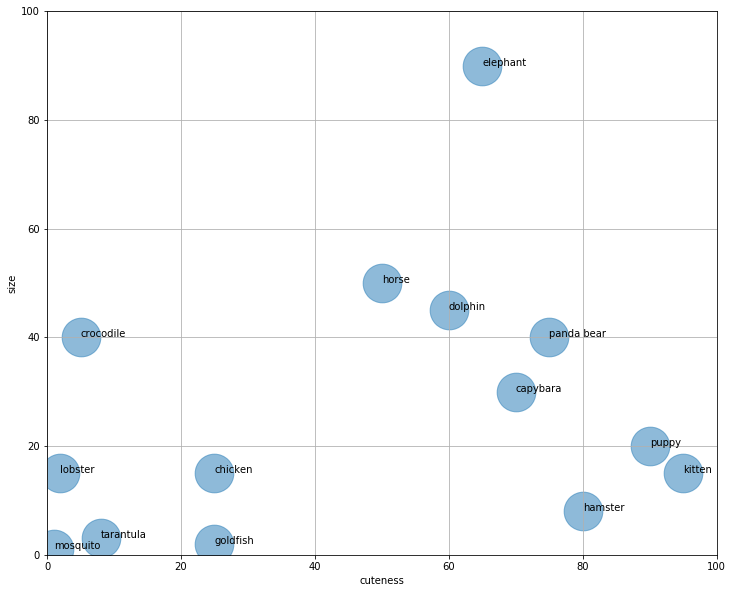

In [77]:
data.reset_index().plot(kind='scatter',x='cuteness',y='size',\
                       s=1500,alpha=0.5)
for index, row in data.iterrows():
    plt.text(row['cuteness'],row['size'],index)
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

Using this plot, we can realize that the closest animal to the capybara is the panda bear. 

In this space, we can quantify how similar two animals are based on their euclidean distance in the space.

In [78]:
def get_animal_array_data( animal ):
    return np.array(data.loc[animal].tolist())

In [79]:
def distance2d( vec1, vec2 ):
    return np.sqrt( np.dot( vec1-vec2,\
                           vec1-vec2 ) )

In [80]:
def get_animal_distances( animal1, animal2 ):
    animal1 = get_animal_array_data(animal1)
    animal2 = get_animal_array_data(animal2)
    return distance2d(animal1, animal2)

In [81]:
print("Distance between a panda bear and capybara: {}".format(get_animal_distances('panda bear','capybara')))
print("Distance between a tarantula and elephant: {}".format(get_animal_distances('tarantula','elephant')))

Distance between a panda bear and capybara: 11.180339887498949
Distance between a tarantula and elephant: 104.0096149401583


We can also write a function to, given a point in animal space, determine the animal that is closest to that point.

In [82]:
def extrapolate_animal_from_point(cuteness, size):
    target_vec = np.array([cuteness,size])
    min_distance = np.inf
    min_distance_animal = ""
    for index, row in data.iterrows():
        distance = distance2d(target_vec, get_animal_array_data(index))
        if distance < min_distance:
            min_distance = distance
            min_distance_animal = index
    return min_distance_animal

The closest animal to size 25 and cuteness 30 should be chicken:

In [89]:
target_vec = [30,25]
minimal_dist_animal = extrapolate_animal_from_point(*target_vec)
print("Animal closest to point ({},{}): {}".format(*target_vec, minimal_dist_animal))

Animal closest to point (30,25): chicken


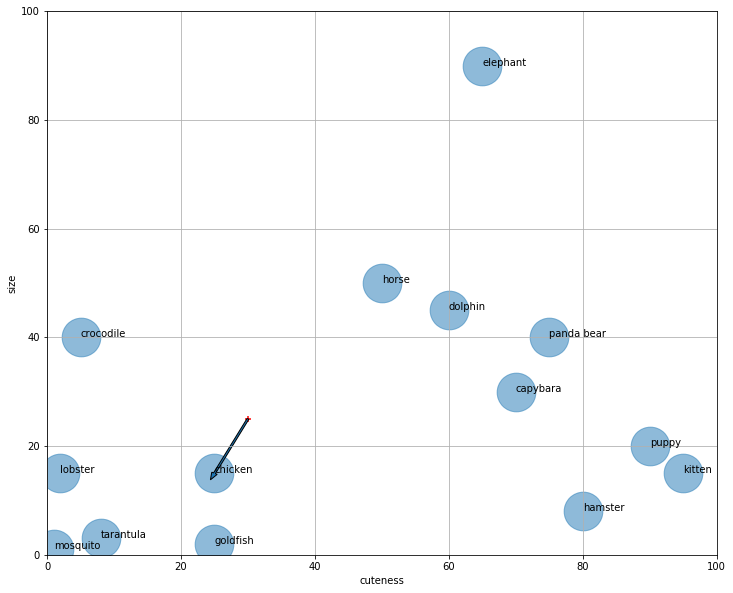

In [95]:
data.reset_index().plot(kind='scatter',x='cuteness',y='size',\
                       s=1500,alpha=0.5)
for index, row in data.iterrows():
    plt.text(row['cuteness'],row['size'],index)
plt.scatter(*target_vec,c='r',marker='+')
minimal_animal = get_animal_array_data(minimal_dist_animal)
vector_diff = (minimal_animal - np.array(target_vec)).tolist()
plt.arrow(*target_vec,*vector_diff,width=0.3 )
plt.grid()
plt.xlim(0,100)
plt.ylim(0,100)
plt.show()

Now let's talk about the vector space of colors. Colors are often represented in computers as vectors with three dimensions: red, green and blue. We'll be using the xkcd data file on colors from [here](https://github.com/dariusk/corpora/blob/master/data/colors/xkcd.json).

A color's RGB vector is converted into a hexadecimal number by converting each of the red, green and blue values into their hexadecimal counterparts and cocnatenating them. The resulting 6 digit number is the hexadecimal number.

In [96]:
import json

In [97]:
color_data = json.loads(open("data/xkcd_colors.json").read())

Colors are represented in hexadecimal format, so we need a function to convert hexadecimal into a tuple of integers:

In [102]:
def hex_to_int( s ):
    # each number is preceded by a pound
    s = s.lstrip("#")
    # int(string, base)
    return (int(s[:2], 16), int(s[2:4], 16), int(s[4:6], 16))

Now we can create a dictionary containing the mappings between the color names to their RGB vectors.

In [103]:
colors = {}
for color in color_data['colors']:
    colors[color['color']] = hex_to_int(color['hex'])

Now we can test it out:

In [104]:
colors['olive']

(110, 117, 14)

In [108]:
np.array(list(colors['red']))

array([229,   0,   0])

In [118]:
def from_tuple_to_np_array( my_tuple ):
    return np.array(list(my_tuple))

def distance_between_colors( color1, color2 ):
    return np.linalg.norm(from_tuple_to_np_array(colors[color1])-\
                                from_tuple_to_np_array(colors[color2]))
def distance_between_coords( coord1, coord2 ):
    return np.linalg.norm(coord1-coord2)

In [113]:
print(distance_between_colors('red','green'))
print(distance_between_colors('red','pink'))

273.70787347096905
232.76812496559748


In order to find the closest colors to some point in RGB space, we can simply compute the distance between our point and every color in the space, then we sort this list. 

In [119]:
def closest( space, coord, n=10 ):
    closest = []
    for key in sorted(space.keys(), key=lambda x: \
        distance_between_coords(from_tuple_to_np_array(space[x]),\
                                from_tuple_to_np_array(coord)))[:n]:
        closest.append(key)
    return closest

In [120]:
closest(colors, colors['red'])

['red',
 'fire engine red',
 'bright red',
 'tomato red',
 'cherry red',
 'scarlet',
 'vermillion',
 'orangish red',
 'cherry',
 'lipstick red']

In [121]:
closest(colors, [150,60,150])

['warm purple',
 'medium purple',
 'ugly purple',
 'light eggplant',
 'purpleish',
 'purplish',
 'purply',
 'light plum',
 'purple',
 'muted purple']

By representing words as vectors in this vector space, we can use the vector operations to operate on those vectors in intuitive ways. For example, purple minus red yields blue:

In [122]:
def subtractv(tuple1, tuple2):
    return from_tuple_to_np_array(tuple1)-from_tuple_to_np_array(tuple2)

In [123]:
closest(colors, subtractv(colors['purple'],colors['red']))

['cobalt blue',
 'royal blue',
 'darkish blue',
 'true blue',
 'royal',
 'prussian blue',
 'dark royal blue',
 'deep blue',
 'marine blue',
 'deep sea blue']

Similarly, we can look at what green plus blue would look like:

In [124]:
def addv(tuple1, tuple2):
    return from_tuple_to_np_array(tuple1)+from_tuple_to_np_array(tuple2)

In [125]:
closest(colors, addv(colors['blue'], colors['green']))

['bright turquoise',
 'bright light blue',
 'bright aqua',
 'cyan',
 'neon blue',
 'aqua blue',
 'bright cyan',
 'bright sky blue',
 'aqua',
 'bright teal']

And finally, what happens if we take the average of black and white? (gray)

In [126]:
def meanv( tuple1, tuple2 ):
    vec1 = from_tuple_to_np_array(tuple1)
    vec2 = from_tuple_to_np_array(tuple2)
    return (vec1 + vec2) / 2

In [127]:
closest(colors, meanv(colors['black'],colors['white']))

['medium grey',
 'purple grey',
 'steel grey',
 'battleship grey',
 'grey purple',
 'purplish grey',
 'greyish purple',
 'steel',
 'warm grey',
 'green grey']

Now, as an academic example, we can compute the average color of the text version of Dracula:

In [129]:
import spacy
nlp = spacy.load("en")